In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import models

import time
import gc

## Read / Import SVHN

In [6]:
NUM_CLASSES = 10

# Transform the data into 'tensors' using the 'transforms' module
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# SVHN training dataset
trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                     transform=transform, download=True)

# SVHN test dataset
testset = torchvision.datasets.SVHN(root='./data', split='test',
                                    transform=transform, download=True)
# Clases for SVHN
classes = [str(i) for i in range(NUM_CLASSES)]

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


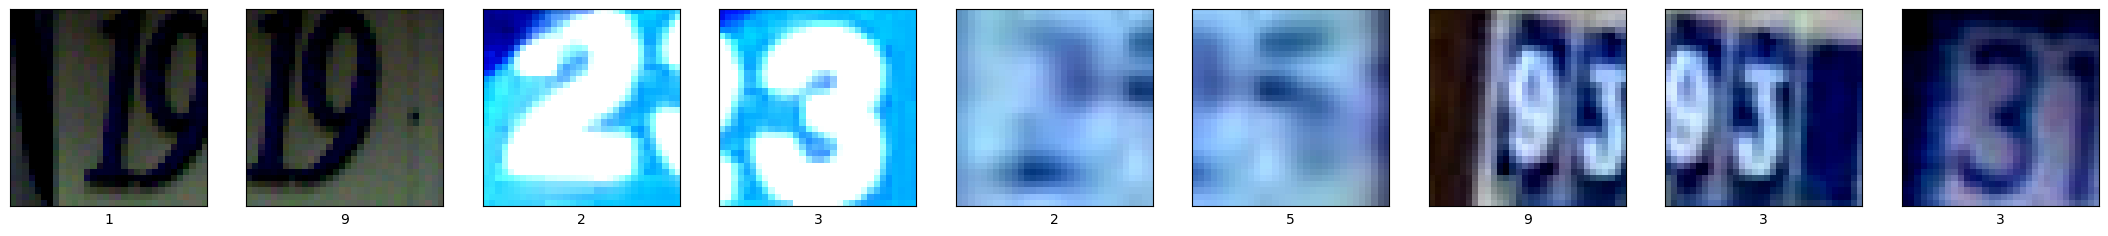

In [7]:
# Show training images and labels
plt.figure(figsize=(30, 30))
for i in range(9):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = trainset[i]
    # Denormalize the image to display it correctly
    image = image / 2 + 0.5
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.xlabel(classes[label])
plt.show()

##Load Data on DataLoader

In [8]:
batch_size = 128
# DataLoader for the training and test dataset
trainloader = DataLoader(dataset = trainset, batch_size = batch_size,
                         num_workers = 0, shuffle = True)
testloader = DataLoader(dataset=testset, batch_size = batch_size,
                        num_workers = 0, shuffle = False)

In [9]:
# Check the dimensions of a batch:
for images, labels in trainloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


## Load the Pre-Trained Model

In [10]:
model = models.resnet18(pretrained=True).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


## Freeze the Model

In [11]:
for param in model.parameters():
    param.requires_grad = False

# Replace the output layer with your own output layer
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

## Create a model, optimizer and criterion

In [15]:
# Hyperparameters
random_seed = 623
learning_rate = 0.0002
num_epochs = 21

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Citerion
criterion = nn.CrossEntropyLoss()

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)

Device: cuda:0


## Train Model

In [ ]:
gc.collect()

17825

In [14]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

In [16]:
# Custom Accuracy Function
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Custom loss Function
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [17]:
start_time = time.time()
for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ## forward + backprop + loss
        logits = model(features)
        cost = criterion(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(trainloader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_acc = compute_accuracy(model, trainloader)
        val_acc = compute_accuracy(model, testloader)
        train_loss = compute_epoch_loss(model, trainloader)
        val_loss = compute_epoch_loss(model, testloader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print('Epoch: %03d/%03d | Train: %.3f%% | Loss: %.3f' % (
              epoch+1, num_epochs,
              compute_accuracy(model, trainloader),
              compute_epoch_loss(model, trainloader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/021 | Batch 0000/0573 | Cost: 2.3617
Epoch: 001/021 | Batch 0050/0573 | Cost: 2.2477
Epoch: 001/021 | Batch 0100/0573 | Cost: 2.2194
Epoch: 001/021 | Batch 0150/0573 | Cost: 2.1629
Epoch: 001/021 | Batch 0200/0573 | Cost: 2.0737
Epoch: 001/021 | Batch 0250/0573 | Cost: 2.0181
Epoch: 001/021 | Batch 0300/0573 | Cost: 2.1246
Epoch: 001/021 | Batch 0350/0573 | Cost: 2.0214
Epoch: 001/021 | Batch 0400/0573 | Cost: 2.0614
Epoch: 001/021 | Batch 0450/0573 | Cost: 2.2048
Epoch: 001/021 | Batch 0500/0573 | Cost: 2.0462
Epoch: 001/021 | Batch 0550/0573 | Cost: 2.0476
Epoch: 001/021 | Train: 31.159% | Loss: 1.967
Time elapsed: 2.59 min
Epoch: 002/021 | Batch 0000/0573 | Cost: 2.0640
Epoch: 002/021 | Batch 0050/0573 | Cost: 2.0043
Epoch: 002/021 | Batch 0100/0573 | Cost: 1.8935
Epoch: 002/021 | Batch 0150/0573 | Cost: 2.0296
Epoch: 002/021 | Batch 0200/0573 | Cost: 2.0414
Epoch: 002/021 | Batch 0250/0573 | Cost: 1.9161
Epoch: 002/021 | Batch 0300/0573 | Cost: 1.9665
Epoch: 002/021 | Ba

In [18]:
# Save the trained model
torch.save(model.state_dict(), 'trainedModel.pth')

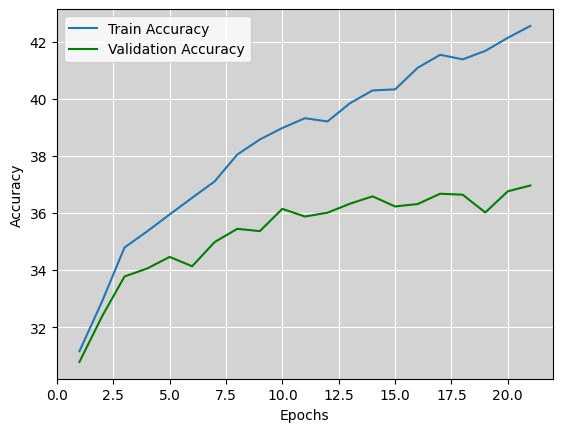

In [19]:
plt.plot(range(1, num_epochs + 1), [acc.detach().cpu() for acc in train_acc_list], label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), [acc.detach().cpu() for acc in val_acc_list], label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(color='white')
plt.gca().set_facecolor('lightgray')
plt.show()

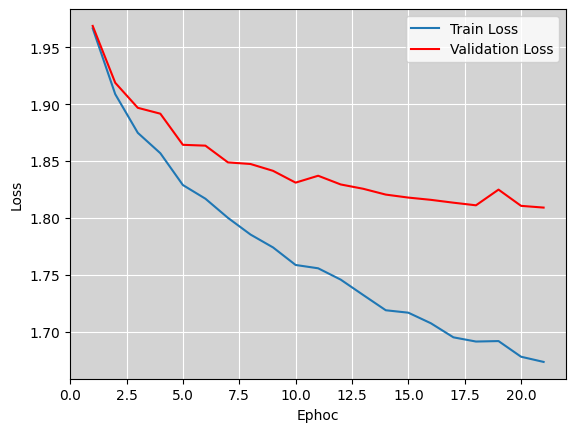

In [20]:
plt.plot(range(1, num_epochs + 1), [loss.detach().cpu().numpy() for loss in train_loss_list], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [loss.detach().cpu().numpy() for loss in val_loss_list], label='Validation Loss', color='red')
plt.xlabel('Ephoc')
plt.ylabel('Loss')
plt.legend()
plt.grid(color='white')
plt.gca().set_facecolor('lightgray')
plt.show()

## Test the Model

In [21]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, testloader)))

Test accuracy: 36.96%


In [86]:
for batch_idx, (features, targets) in enumerate(testloader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)

In [87]:
predicted_labels

tensor([5, 5, 3, 1, 2, 0, 3, 1, 1, 5, 1, 2, 1, 1, 4, 4, 7, 1, 2, 1, 2, 0, 2, 5,
        3, 5, 1, 7, 2, 2, 1, 2, 4, 6, 4, 1, 6, 1, 1, 1, 3, 1, 5, 0, 1, 1, 1, 6,
        8, 2, 2, 5, 5, 1, 4, 1, 1, 1, 1, 6, 1, 3, 2, 4, 4, 0, 1, 2, 0, 2, 5, 0,
        1, 1, 1, 2, 2, 6, 2, 4, 4, 1, 7, 0, 2, 1, 1, 1, 1, 1, 4, 4, 5, 2, 1, 2,
        2, 4, 2, 1, 7, 1, 9, 5, 6, 5, 1, 1, 8, 6, 1, 5, 3, 3, 1, 4, 2, 1, 5, 2,
        8, 3, 1, 1, 6, 6, 1, 2], device='cuda:0')

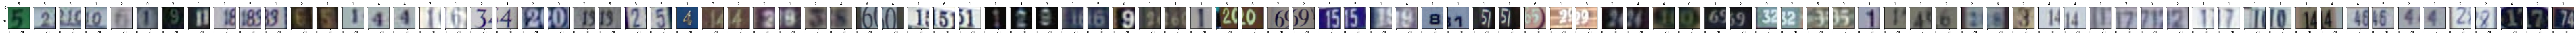

In [88]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 100

fig, axes = plt.subplots(nrows=1, ncols=n_images,
                         sharex=True, sharey=True, figsize=(150, 70.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225]))
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])


## Select Image

In [119]:
selected_image = orig_images[85].unsqueeze(0)

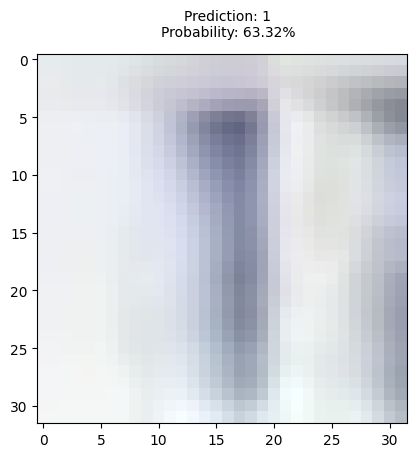

In [120]:
model.eval()
with torch.no_grad():
    logits_original = model(selected_image.to(DEVICE))
    _, predicted_original = torch.max(logits_original, 1)

# Accuracy
accuracy = torch.softmax(logits_original, dim=1)[0][predicted_original.item()].item() * 100

plt.imshow(selected_image.squeeze().permute(1, 2, 0))
plt.text(16, -2, "Prediction: {}\nProbability: {:.2f}%".format(classes[predicted_original.item()], accuracy), size=10, ha="center")
plt.show()

## PGD attack

In [142]:
import torchattacks
import torchvision.transforms as transforms

atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=10, random_start=True)
adv_image = atk(selected_image.to(DEVICE), predicted_original.to(DEVICE))

# Get the predictions

with torch.no_grad():
    logits_adversarial = model(adv_image)
    _, predicted_adversarial = torch.max(logits_adversarial, 1)

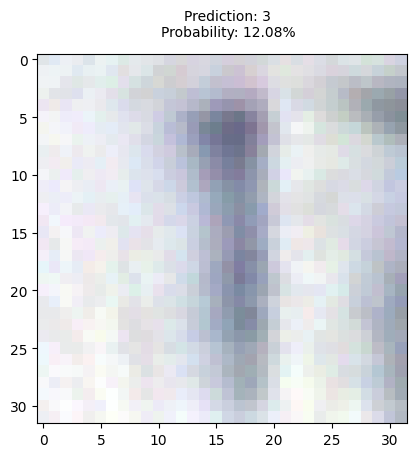

In [143]:
import torch.nn.functional as F

output_probs = F.softmax(logits_adversarial, dim=1)
x_pred_prob = torch.max(output_probs.data, 1)[0][0].item() * 100
rounded_pred_prob = round(x_pred_prob, 4)

plt.imshow(adv_image.squeeze().permute(1, 2, 0).cpu())
plt.text(16, -2, "Prediction: {}\nProbability: {:.2f}%".format(classes[predicted_adversarial.item()], rounded_pred_prob), size=10, ha="center")
plt.show()

## Loading Model

In [123]:
model = models.resnet18(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [124]:
for param in model.parameters():
    param.requires_grad = False

# Replace the output layer with your own output layer
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, NUM_CLASSES)
)

In [134]:
# Hyperparameters
random_seed = 623
learning_rate = 0.0002
num_epochs = 12

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Citerion
criterion = nn.CrossEntropyLoss()

In [128]:
model.load_state_dict(torch.load('trainedModel.pth'))

<All keys matched successfully>

In [130]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)
# Set my pretrained model to be run on GPU
model = model.to(DEVICE)

Device: cuda:0


## Standard Testing

In [131]:
correct = 0
total = 0

with torch.no_grad():
    for data, targets in testloader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        outputs = model(data)

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy {100 * correct // total} %')

Accuracy 35 %


In [132]:
# Custom Accuracy Function
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Custom loss Function
def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')

            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

## PGD Attack

In [133]:
def pgd_attack(model, images, epsilon, alpha, num_steps, device):
    images = images.to(device)

    # Create a copy of the original images for PGD iterations
    adv_images = images.clone().detach()
    adv_images.requires_grad = True

    for _ in range(num_steps):
        logits = model(adv_images)
        loss = F.cross_entropy(logits, torch.argmax(logits, dim=1))

        # Zero out previous gradients and backpropagate the loss
        model.zero_grad()
        loss.backward()

        # Create adversarial examples using PGD
        data_grad = adv_images.grad.data
        perturbed_images = adv_images + alpha * data_grad.sign()

        # Project the perturbed images back to the epsilon ball around the original images
        perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
        perturbed_images = torch.clamp(perturbed_images, 0, 1)
        adv_images = perturbed_images.detach()
        adv_images.requires_grad = True

    return adv_images

## Adversarial Training

In [135]:
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 1.0]

# Listas para almacenar los valores de Accuracy y Epsilon
accuracy_list = []
epsilon_list = []

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

start_time = time.time()
for epoch in range(num_epochs):

    # Seleccionar un epsilon para esta época
    epsilon = epsilons[epoch % len(epsilons)]

    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # Generar ejemplos adversarios usando el ataque PGD
        alpha = 0.3
        num_steps = 7

        adv_features = pgd_attack(model, features, epsilon, alpha, num_steps, DEVICE)

        ## forward + backprop + loss
        logits = model(adv_features)
        cost = criterion(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Epsilon: %.2f | Cost: %.4f'
                  % (epoch + 1, num_epochs, batch_idx,
                     len(trainloader), epsilon, cost))

    # Evaluación del modelo en el conjunto de prueba original
    test_accuracy = evaluate_model(model, testloader, DEVICE)

    accuracy_list.append(test_accuracy)
    epsilon_list.append(epsilon)

    print('Epoch: %03d/%03d | Epsilon: %.2f | Test Accuracy: %.3f%%'
          % (epoch + 1, num_epochs, epsilon, test_accuracy))

    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

Epoch: 001/012 | Batch 0000/0573 | Epsilon: 0.05 | Cost: 2.0951
Epoch: 001/012 | Batch 0050/0573 | Epsilon: 0.05 | Cost: 2.2004
Epoch: 001/012 | Batch 0100/0573 | Epsilon: 0.05 | Cost: 2.2654
Epoch: 001/012 | Batch 0150/0573 | Epsilon: 0.05 | Cost: 2.0208
Epoch: 001/012 | Batch 0200/0573 | Epsilon: 0.05 | Cost: 2.0569
Epoch: 001/012 | Batch 0250/0573 | Epsilon: 0.05 | Cost: 2.1302
Epoch: 001/012 | Batch 0300/0573 | Epsilon: 0.05 | Cost: 2.1586
Epoch: 001/012 | Batch 0350/0573 | Epsilon: 0.05 | Cost: 2.0981
Epoch: 001/012 | Batch 0400/0573 | Epsilon: 0.05 | Cost: 2.2059
Epoch: 001/012 | Batch 0450/0573 | Epsilon: 0.05 | Cost: 2.1118
Epoch: 001/012 | Batch 0500/0573 | Epsilon: 0.05 | Cost: 2.0875
Epoch: 001/012 | Batch 0550/0573 | Epsilon: 0.05 | Cost: 2.1569
Epoch: 001/012 | Epsilon: 0.05 | Test Accuracy: 22.215%
Time elapsed: 1.47 min
Epoch: 002/012 | Batch 0000/0573 | Epsilon: 0.10 | Cost: 2.1240
Epoch: 002/012 | Batch 0050/0573 | Epsilon: 0.10 | Cost: 2.1724
Epoch: 002/012 | Batch 01

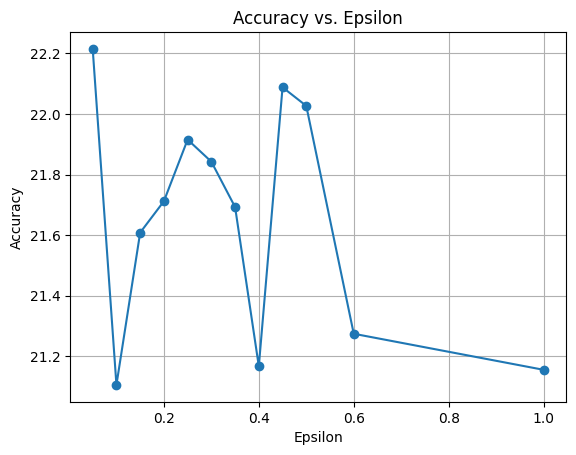

In [136]:
plt.plot(epsilon_list, accuracy_list, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon')
plt.grid(True)
plt.show()

In [138]:
for batch_idx, (features, targets) in enumerate(testloader):

    features = features
    targets = targets
    break

logits = model(features.to(DEVICE))
_, predicted_labels = torch.max(logits, 1)

predicted_labels

tensor([1, 2, 6, 0, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 9, 9], device='cuda:0')

In [139]:
selected_image = orig_images[85].unsqueeze(0)

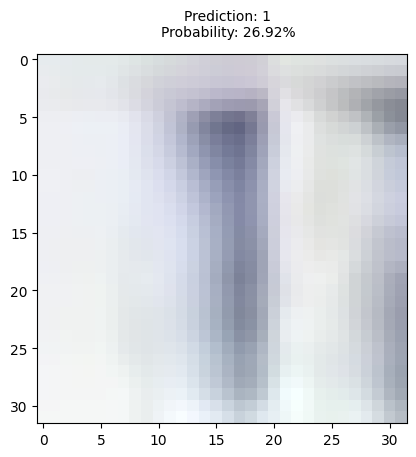

In [141]:
model.eval()
with torch.no_grad():
    logits_original = model(selected_image.to(DEVICE))
    _, predicted_original = torch.max(logits_original, 1)

# Accuracy
accuracy = torch.softmax(logits_original, dim=1)[0][predicted_original.item()].item() * 100

plt.imshow(selected_image.squeeze().permute(1, 2, 0))
plt.text(16, -2, "Prediction: {}\nProbability: {:.2f}%".format(classes[predicted_original.item()], accuracy), size=10, ha="center")
plt.show()